In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

seed(888)

Load data

In [20]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("2_brain_test.pkl")
brain_train = pd.read_pickle("2_brain_train.pkl")
main_test = pd.read_pickle("2_main_test.pkl")
main_train = pd.read_pickle("2_main_train.pkl")
main_test_all = pd.read_pickle("2_main_test_all.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)
main_train = pd.DataFrame(main_train)
main_test_all = pd.DataFrame(main_test_all)

# Brain Age Prediction by Segmentation

## 1. A2009s Segmentation (Thickness and Area)

In [21]:
main_test_reset = main_test
main_train_reset = main_train
brain_train_reset = brain_train
brain_test_reset = brain_test

# fresufer a2009s thickness area
a2009s_train = brain_train.iloc[:,1657:2544:2]
a2009s_test = brain_test.iloc[:,1657:2544:2]
age_train = brain_train["Age"]
age_test = brain_test["Age"]
a2009s_train = pd.concat([a2009s_train,age_train],axis = 1)
a2009s_test = pd.concat([a2009s_test,age_test],axis = 1)
print(a2009s_test.shape)
# delete rows with nan values (it's not a lot here, so no imputing needed)
nan_test = a2009s_test[a2009s_test.isnull().any(axis=1)].index
nan_train = a2009s_train[a2009s_train.isnull().any(axis=1)].index
a2009s_testing = a2009s_test.dropna(axis=0)
a2009s_training = a2009s_train.dropna(axis=0)
main_test = main_test.drop(nan_test)
main_train = main_train.drop(nan_train)
print(a2009s_testing.shape)

# freesurfer a2009s
X_train = a2009s_training.iloc[:,:-1]
Y_train = a2009s_training.iloc[:,-1]
X_test = a2009s_testing.iloc[:,:-1]
Y_test = a2009s_testing.iloc[:,-1]

(5298, 445)
(5286, 445)


Cross validation

In [22]:
# set of alphas to try (=penalization)
alpha_parameters = np.power(10,np.linspace(start=-3, stop=5, num=100))

# standardize x-data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))


The MAE for cross-validation (Ridge): 4.275383957193209


Brain Age model predicting test data

In [23]:
# BrainAge model for testing data
# model trained on training tested on test
# model initialization - options to use Lasso, Ridge or SVM

model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000)
model_Ridge = RidgeCV(alphas = alpha_parameters)
model_SVR = SVR(kernel = 'rbf')

# train model on training data
model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
model_SVR.fit(X_train_std,Y_train)

# get predicted values for test set
y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
y_pred_SVR = model_SVR.predict(X_test_std)
#main_test["BA ASEG"] = y_pred

# calculate brain age gap
brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
brain_age_delta_SVR = y_pred_SVR-Y_test
#main_test["BA ASEG Delta"] = brain_age_delta

# check whether brain age gap and age are correlated
# correlation = stats.pearsonr(brain_age_delta, Y_test)
# print(correlation)

# get mean absolute error (MAE)
print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))


Plots

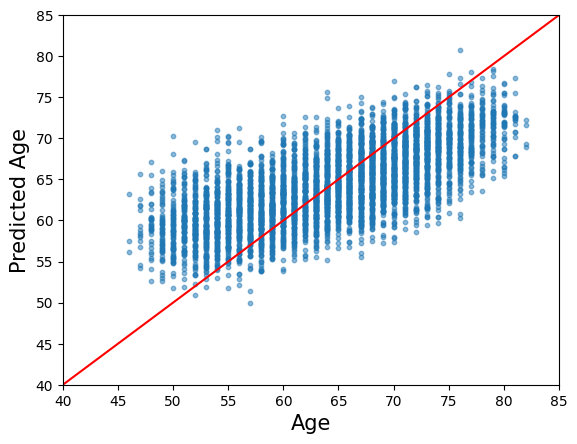

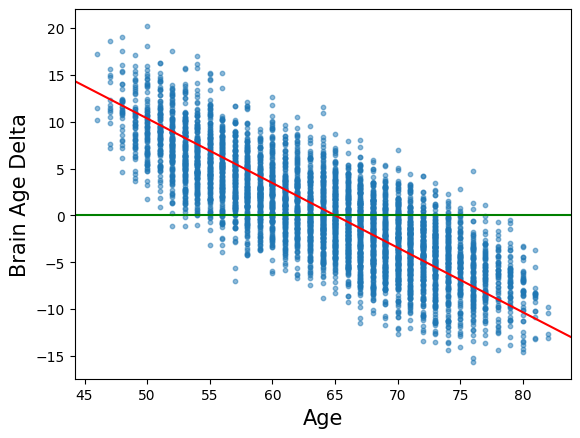

In [ ]:
#plot figure with x: actual age Y: predicted age, and a line with slope 1 for reference
plt.figure()
plt.scatter(Y_test, y_pred_SVR, alpha=0.5, s=10)
plt.axline((60,60), slope=1, color='r')
#plt.axline((60,60),slope=coef, color="black")
plt.xticks(range(40,90,5))
plt.yticks(range(40,90,5))
plt.ylabel('Predicted Age', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.show()

plt.figure()
plt.scatter(Y_test,brain_age_delta_SVR, alpha=0.5, s=10)
plt.axline((65,0), slope=-0.69, color="r")
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

## Brain Age Correction

Coefficient and Intercept: 0.5254167749294537 30.5777528588997


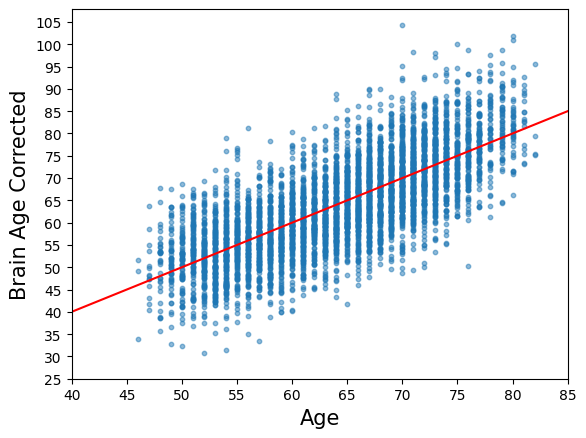

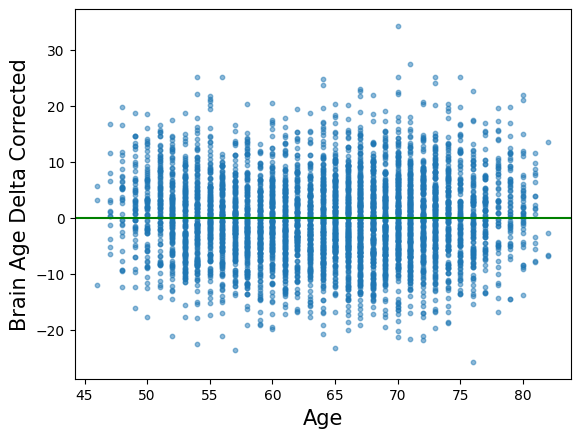

In [ ]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage = vfunc(y_pred_Ridge)
corr_brainage_delta = corr_brainage-Y_test

plt.figure()
plt.scatter(Y_test, corr_brainage, alpha=0.5, s=10)
#plt.axline((60,5), slope=-0.69, color="r")
#plt.axline((60,0),slope=1, color = "g")
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

## 2. ASEG Segmentation

In [ ]:
brain_test = brain_test_reset
brain_train = brain_train_reset
main_test = main_test_reset
main_train = main_train_reset

# Freesurfer ASEG
# select Freesurfer ASEG for training data
whole_brain = brain_train.iloc[:,27:70:2]
left_hemi = brain_train.iloc[:,103:134:2]
right_hemi = brain_train.iloc[:,165:196:2]
age = brain_train["Age"]
ASEG_train = pd.DataFrame(pd.concat([whole_brain,left_hemi, right_hemi,age],axis = 1))

# select Freesurfer ASEG for testing data
whole_brain = brain_test.iloc[:,27:70:2]
left_hemi = brain_test.iloc[:,103:134:2]
right_hemi = brain_test.iloc[:,165:196:2]
age = brain_test["Age"]
ASEG_test = pd.DataFrame(pd.concat([whole_brain,left_hemi, right_hemi,age],axis = 1))

# delete rows with nan values (it's not a lot here, so no imputing needed)
nan_test = ASEG_test[ASEG_test.isnull().any(axis=1)].index
nan_train = ASEG_train[ASEG_train.isnull().any(axis=1)].index
ASEG_testing = ASEG_test.dropna(axis=0)
ASEG_training = ASEG_train.dropna(axis=0)
main_test = main_test.drop(nan_test)
main_train = main_train.drop(nan_train)

# freesurfer aseg
X_train = ASEG_training.iloc[:,:-1]
Y_train = ASEG_training.iloc[:,-1]
X_test = ASEG_testing.iloc[:,:-1]
Y_test = ASEG_testing.iloc[:,-1]

# model initialization - options to use Lasso, Ridge or SVM
#model = LassoCV(alphas = alpha_parameters, max_iter=100000)
#model = RidgeCV(alphas = alpha_parameters)
model = SVR(kernel = 'rbf')

# train model on training data
model.fit(X_train_std,Y_train)

# get predicted values for test set
y_pred = model.predict(X_test_std)
#main_test["BA ASEG"] = y_pred

# calculate brain age gap
brain_age_delta = y_pred-Y_test
#main_test["BA ASEG Delta"] = brain_age_delta

# check whether brain age gap and age are correlated
# correlation = stats.pearsonr(brain_age_delta, Y_test)
# print(correlation)

# get mean absolute error (MAE)
print("The MAE for testing set:", mean_absolute_error(Y_test,y_pred))



### Correction

In [ ]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage = vfunc(y_pred)
corr_brainage_delta = corr_brainage-Y_test

plt.figure()
plt.scatter(Y_test, corr_brainage, alpha=0.5, s=10)
#plt.axline((60,5), slope=-0.69, color="r")
#plt.axline((60,0),slope=1, color = "g")
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

!! compute for excluded people
add BrainAge to main_test
add another segmentation